In [49]:
import os
import time

# import sklearn.linear_model
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model as sklm
import sklearn.neural_network as sknn
import vaex
import vaex.ml
import vaex.ml.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# vaex.settings.main.thread_count = 20

In [50]:
features = ['EventType', 'EventDetails', 'EventCountry', 'Actor1Code', 'Actor1Name']
target = 'AvgTone'

In [51]:
def vx_reader(folder):
    print("Starting read")
    read_time = time.time()
    df = vaex.open(folder,
                   dtype={'Actor1Code': str,
                          'Actor1Name': str,
                          'EventCode': str,
                          'ActionGeo_ADM1Code': str,
                          'SQLDATE': str})
    print("Read completed in", time.time() - read_time, "seconds")
    print("Starting cleanup")
    clean_time = time.time()
    df.dropna()
    df = df[df.NumMentions > 5000]
    df = df[df.SQLDATE > 20000000]
    df['EventType'] = df.EventCode.str.slice(start=0, stop=2)
    df['EventDetails'] = df.EventCode.str.slice(start=2)
    df['EventCountry'] = df.ActionGeo_ADM1Code.str.slice(start=0, stop=2)
    df['EventRegion'] = df.ActionGeo_ADM1Code.str.slice(start=2)
    # df['Year'] = df.SQLDATE.str.slice(start=0, stop=4)
    # df['Month'] = df.SQLDATE.str.slice(start=4, stop=6)
    # df['Month'] = df.Month.astype('str')
    df = df.drop(['EventCode', 'ActionGeo_ADM1Code'])
    df = df.dropna()
    # df = df[df.NumMentions > 500]
    print("Cleanup completed in", time.time() - clean_time, "seconds")
    test = df[df.SQLDATE > 20200000]
    train = df[df.SQLDATE < 20200000]
    # print(df.head(5))
    return test, train, df


test_df, df, raw = vx_reader("data")

Starting read
Read completed in 0.04649758338928223 seconds
Starting cleanup
Cleanup completed in 1.5895001888275146 seconds


In [52]:
def binary_encode(df, test_df, features):
    binary_encoder = vaex.ml.MultiHotEncoder(features=features)
    binary_encoded_df = binary_encoder.fit_transform(df)
    binary_encoded_test = binary_encoder.transform(test_df)
    return binary_encoded_df, binary_encoded_test


bin_df, bin_test = binary_encode(df, test_df, features)

<function matplotlib.pyplot.show(close=None, block=None)>

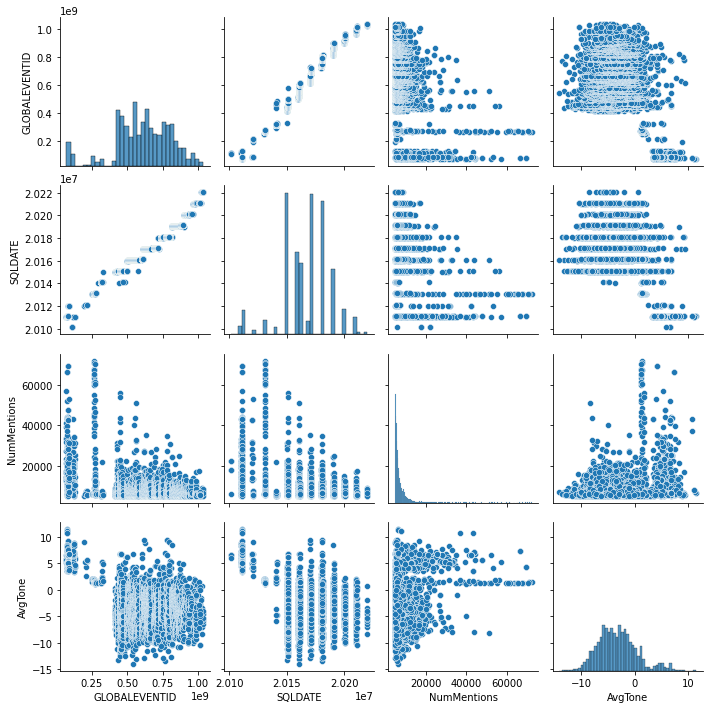

In [53]:
bin_pd = bin_df.to_pandas_df()
test_pd = bin_test.to_pandas_df()
raw_pd = raw.to_pandas_df()
sns.pairplot(raw_pd)
plt.show

In [54]:
print(test_pd.head())

   GLOBALEVENTID   SQLDATE Actor1Code     Actor1Name  NumMentions   AvgTone  \
0      957017856  20201130        GBR        BRITISH         5171 -1.589066   
1      958212977  20201207        USA  UNITED STATES         5756 -1.289639   
2      959192915  20201212        USA          TEXAS         7182 -1.965289   
3      959192730  20201212        USA  UNITED STATES         6865 -1.838532   
4      959619869  20201215        GOV      PRESIDENT         5334 -3.296626   

  EventType EventDetails EventCountry EventRegion  ...  Actor1Name_1  \
0        03            6           UK          H9  ...             0   
1        04            2           US          DC  ...             1   
2        12            0           US          TX  ...             1   
3        02            0           US          TX  ...             1   
4        11            0           US          DC  ...             0   

   Actor1Name_2  Actor1Name_3  Actor1Name_4  Actor1Name_5  Actor1Name_6  \
0             0  

In [55]:
def lin_reg(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = pd.DataFrame(df['AvgTone'])
    print(y.head())
    y_test = pd.DataFrame(test_df['AvgTone'])
    print(y_test.head())
    model = sklm.LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    score = model.score(X_test,y_test)
    print(score)
    # print(preds)
    return preds, score

lin_reg_preds, lin_reg_score = lin_reg(bin_pd, test_pd)


   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         5058        03            6            0            0            0   
1        14740        13           84            0            0            1   
2        31536        01            0            0            0            0   
3         6851        12            0            0            0            1   
4         6698        12            0            0            0            1   

   EventType_3  EventType_4  EventType_5  EventDetails_0  ...  Actor1Name_1  \
0            0            1            1               1  ...             0   
1            1            0            1               1  ...             0   
2            0            0            1               0  ...             0   
3            1            0            0               0  ...             0   
4            1            0            0               0  ...             0   

   Actor1Name_2  Actor1Name_3  Actor1Name_4 

In [56]:
def random_forest(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.ensemble.RandomForestRegressor(max_depth = 2, random_state=0)
    model.fit(X, y)
    path = model.decision_path(X)
    score = model.score(X_test, y_test)
    print(score)
    return path, score

rf_path, rf_score = random_forest(bin_pd, test_pd)

   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         5058        03            6            0            0            0   
1        14740        13           84            0            0            1   
2        31536        01            0            0            0            0   
3         6851        12            0            0            0            1   
4         6698        12            0            0            0            1   

   EventType_3  EventType_4  EventType_5  EventDetails_0  ...  Actor1Name_1  \
0            0            1            1               1  ...             0   
1            1            0            1               1  ...             0   
2            0            0            1               0  ...             0   
3            1            0            0               0  ...             0   
4            1            0            0               0  ...             0   

   Actor1Name_2  Actor1Name_3  Actor1Name_4 

In [57]:
def svm(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.svm.SVR()
    model.fit(X, y)
    predict = model.predict(X)
    score = model.score(X_test, y_test)
    print(score)
    return predict, score

svm_pred, svm_score = svm(bin_pd, test_pd)

   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         5058        03            6            0            0            0   
1        14740        13           84            0            0            1   
2        31536        01            0            0            0            0   
3         6851        12            0            0            0            1   
4         6698        12            0            0            0            1   

   EventType_3  EventType_4  EventType_5  EventDetails_0  ...  Actor1Name_1  \
0            0            1            1               1  ...             0   
1            1            0            1               1  ...             0   
2            0            0            1               0  ...             0   
3            1            0            0               0  ...             0   
4            1            0            0               0  ...             0   

   Actor1Name_2  Actor1Name_3  Actor1Name_4 

In [58]:
def nn(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sknn.MLPRegressor()
    model.fit(X, y)
    preds = model.predict(X)
    score = model.score(X_test, y_test)
    print(score)
    return preds, score

nn_preds, nn_score = nn(bin_pd, test_pd)

   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         5058        03            6            0            0            0   
1        14740        13           84            0            0            1   
2        31536        01            0            0            0            0   
3         6851        12            0            0            0            1   
4         6698        12            0            0            0            1   

   EventType_3  EventType_4  EventType_5  EventDetails_0  ...  Actor1Name_1  \
0            0            1            1               1  ...             0   
1            1            0            1               1  ...             0   
2            0            0            1               0  ...             0   
3            1            0            0               0  ...             0   
4            1            0            0               0  ...             0   

   Actor1Name_2  Actor1Name_3  Actor1Name_4 

In [59]:
print("R2's:")
print("LinReg:", lin_reg_score)
print("Random Forest:", rf_score)
print("SVR:", svm_score)
print("NN:", nn_score)

R2's:
LinReg: -0.2996467940081886
Random Forest: 0.11085281780946865
SVR: -0.031506627778215
NN: 0.09992098300583796
